# Model Development

## Feature Integration
This script integrates multiple feature tables, including **application** (the original main table), **Add** (features generated from the main table), **External** (features generated from auxiliary tables), and **Financial** (Key financial features), into unified training and testing datasets.  
It automatically cleans column names, removes duplicate or invalid columns, and merges all sources on the key `SK_ID_CURR` to produce consistent, model-ready feature files.

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Integrate Home Credit CSV Files
===============================
Functions:
- Integrate Add / External / Financial tables into the main table application_xxx.csv
- Generate All_application_train.csv and All_application_test.csv separately
- Automatically remove the TARGET column from Add_application_train.csv and External_application_train.csv
- Automatically drop duplicate columns
- Automatically sanitize illegal column name characters
(to avoid LightGBM error: “Do not support special JSON characters”)
"""

import pandas as pd
import os
import re
from collections import Counter


def sanitize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Clean column names (replace illegal characters and ensure uniqueness)."""
    original_cols = list(df.columns)
    new_cols = []
    counter = Counter()

    for c in original_cols:
        # Replace illegal characters
        safe = re.sub(r'[^A-Za-z0-9_]', '_', c.strip())
        # Avoid empty names
        if not safe:
            safe = "unnamed_col"
        # Ensure unique column names
        base = safe
        while safe in counter:
            counter[base] += 1
            safe = f"{base}__{counter[base]}"
        counter[safe] += 1
        new_cols.append(safe)

    changed = sum([a != b for a, b in zip(original_cols, new_cols)])
    if changed > 0:
        print(f"  [Column Sanitization] Modified {changed} column names, e.g.:")
        for i, (a, b) in enumerate(zip(original_cols, new_cols)):
            if a != b:
                print(f"    {a} -> {b}")
            if i > 5:
                break

    df.columns = new_cols
    return df


def merge_application_group(prefix: str = "application"):
    """
    Merge the specified prefix group (train/test).
    """
    # File paths
    app_path = f"Features/{prefix}.csv"
    add_path = f"Features/Add_{prefix}.csv"
    ext_path = f"Features/External_{prefix}.csv"
    fin_path = f"Features/Finacial_{prefix}.csv"

    # Load main table
    print(f"Reading main table: {app_path}")
    app_df = pd.read_csv(app_path)
    app_df = sanitize_columns(app_df)
    print(f"  shape = {app_df.shape}")

    # Sequentially merge Add / External / Financial
    for sub_path in [add_path, ext_path, fin_path]:
        if not os.path.exists(sub_path):
            print(f"[Skipped] File not found: {sub_path}")
            continue

        print(f"Merging file: {sub_path}")
        sub_df = pd.read_csv(sub_path)
        sub_df = sanitize_columns(sub_df)

        # Remove TARGET column for Add/External train versions
        if ("Add_application_train" in sub_path) or ("External_application_train" in sub_path):
            if "TARGET" in sub_df.columns:
                sub_df = sub_df.drop(columns=["TARGET"])
                print("  Removed TARGET column (to avoid duplication)")

        # Merge on SK_ID_CURR
        app_df = app_df.merge(sub_df, on="SK_ID_CURR", how="left")

    # Remove duplicate columns
    before = len(app_df.columns)
    app_df = app_df.loc[:, ~app_df.columns.duplicated()]
    after = len(app_df.columns)
    if after < before:
        print(f"Removed {before - after} duplicate columns")

    # Output
    out_path = f"Features/All_{prefix}.csv"
    app_df.to_csv(out_path, index=False)
    print(f"Output saved: {out_path}  shape = {app_df.shape}\n")


if __name__ == "__main__":
    # Process both train and test sets
    merge_application_group("application_train")
    merge_application_group("application_test")

    # Compare column differences
    train = pd.read_csv("Features/All_application_train.csv", nrows=5)
    test  = pd.read_csv("Features/All_application_test.csv", nrows=5)

    only_in_train = [c for c in train.columns if c not in test.columns]
    only_in_test  = [c for c in test.columns  if c not in train.columns]

    print(f"Columns only in train: {len(only_in_train)}")
    for c in only_in_train[:50]:
        print("  +", c)
    print(f"\nColumns only in test: {len(only_in_test)}")
    for c in only_in_test[:50]:
        print("  +", c)

Reading main table: Features/application_train.csv
  shape = (307511, 122)
Merging file: Features/Add_application_train.csv
  [Column Sanitization] Modified 55 column names, e.g.:
  Removed TARGET column (to avoid duplication)
Merging file: Features/External_application_train.csv
  Removed TARGET column (to avoid duplication)
Merging file: Features/Finacial_application_train.csv
Output saved: Features/All_application_train.csv  shape = (307511, 773)

Reading main table: Features/application_test.csv
  shape = (48744, 121)
Merging file: Features/Add_application_test.csv
  [Column Sanitization] Modified 55 column names, e.g.:
Merging file: Features/External_application_test.csv
Merging file: Features/Finacial_application_test.csv
Output saved: Features/All_application_test.csv  shape = (48744, 772)

Columns only in train: 1
  + TARGET

Columns only in test: 0


## Feature Flitering

This script performs Stage 0–1 feature screening for the Home Credit dataset. It first audits and cleans features by removing constant, highly missing, or duplicate columns, then applies lightweight univariate filters—including out-of-fold AUC, mutual information, and Spearman correlation—to select informative features for downstream modeling.

It generates train and test sets with filtered features to examine whether it is necessary to remove those relatively poor-performing features.

In [9]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Home Credit - Feature Screening (Stage 0 & Stage 1 Only)
=======================================================

Inputs:
  - All_application_train.csv  (must contain TARGET and SK_ID_CURR)
  - All_application_test.csv   (must contain SK_ID_CURR)

Stages implemented:
  Stage 0: Audit & hygiene
           - Drop constant columns
           - Drop columns with high missing rate
           - Drop duplicate columns (by content hash)
  Stage 1: Lightweight univariate filters:
           - OOF single-feature AUC (numeric: median→rank; categorical: OOF frequency encoding)
           - Mutual Information (type-aware)
           - Spearman |rho| (numeric & ordinalized categorical)

Outputs:
  - feature_audit.csv
  - stage1_metrics.csv
  - selected_features.json        (Stage 1 pass list)                [optional]
  - fli_application_train.csv     (ID, TARGET, Stage1-pass feats)   [optional]
  - fli_application_test.csv      (ID, Stage1-pass feats)           [optional]

CLI:
  python stage01_only.py --train application_train.csv --test application_test.csv
  # Disable exporting simplified feature files:
  python stage01_only.py --no-export-fli
"""

from __future__ import annotations
import os, json, math, hashlib, warnings, argparse
from dataclasses import dataclass
from typing import List, Tuple, Dict, Optional

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import spearmanr

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


# ---------------------------- Config ---------------------------- #
@dataclass
class Config:
    seed: int = 42
    n_splits: int = 5
    id_col: str = "SK_ID_CURR"
    target_col: str = "TARGET"

    # Stage 0
    high_missing_thr: float = 0.98           # drop if missing rate > threshold
    near_constant_unique_ratio: float = 1e-8 # drop if unique/rows <= ratio
    check_duplicates: bool = True

    # Stage 1 thresholds
    auc_thr: float = 0.51                    # pass if max(AUC,1-AUC) >= threshold
    mi_quantile: float = 0.60                # pass if MI >= this quantile among all features
    rho_thr: float = 0.05                    # pass if |Spearman rho| >= threshold


CFG = Config()


# ---------------------------- Utils ---------------------------- #
def set_seed(seed: int):
    np.random.seed(seed)


def read_data(train_path: str, test_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    print(f"[Load] Reading {train_path} and {test_path} ...")
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    assert CFG.target_col in train.columns, f"{CFG.target_col} missing in train"
    assert CFG.id_col in train.columns and CFG.id_col in test.columns, "ID column missing"
    print(f"[Load] train: {train.shape}, test: {test.shape}")
    return train, test


def column_hash(s: pd.Series) -> str:
    """Compute a robust hash of a column (including NaNs)."""
    try:
        v = s.to_numpy()
        mask = pd.isna(v)
        v2 = np.where(mask, None, v)
        payload = pd.Series(v2).to_json(orient="values").encode("utf-8")
    except Exception:
        payload = s.astype(str).to_json(orient="values").encode("utf-8")
    return hashlib.md5(payload).hexdigest()


# ---------------------------- Stage 0 ---------------------------- #
def stage0_audit_and_clean(train: pd.DataFrame, test: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, List[str]]:
    print("\n[Stage 0] Auditing and cleaning ...")

    # Combine full data (without TARGET) for unified statistics
    df_all = pd.concat([
        train.drop(columns=[CFG.target_col]),
        test.copy()
    ], axis=0, ignore_index=True)

    n_rows_all = df_all.shape[0]
    base_stats = []
    for col in df_all.columns:
        dtype = str(df_all[col].dtype)
        missing_rate = float(df_all[col].isna().mean())
        nunique = int(df_all[col].nunique(dropna=True))
        near_const = (nunique / max(n_rows_all, 1)) <= CFG.near_constant_unique_ratio
        high_miss = missing_rate > CFG.high_missing_thr
        base_stats.append({
            "column": col,
            "dtype": dtype,
            "missing_rate": missing_rate,
            "nunique": nunique,
            "near_constant": near_const,
            "high_missing": high_miss,
        })
    audit_df = pd.DataFrame(base_stats)

    # Check for duplicate columns (by content hash)
    audit_df["duplicate"] = False
    drop_cols = set(audit_df.loc[audit_df["near_constant"] | audit_df["high_missing"], "column"].tolist())

    if CFG.check_duplicates:
        print("[Stage 0] Checking duplicate columns by content hash ...")
        seen_hash: Dict[str, str] = {}
        for col in df_all.columns:
            if col in drop_cols or col == CFG.id_col:
                continue
            h = column_hash(df_all[col])
            if h in seen_hash:
                audit_df.loc[audit_df["column"] == col, "duplicate"] = True
                drop_cols.add(col)
            else:
                seen_hash[h] = col

    # Always keep ID column
    drop_cols.discard(CFG.id_col)

    # Save audit report
    audit_df.to_csv("feature_audit.csv", index=False)
    print(f"[Stage 0] Audit saved: feature_audit.csv; proposed dropping {len(drop_cols)} columns")

    if drop_cols:
        sample = sorted(list(drop_cols))[:12]
        print(f"[Stage 0] Dropping {len(drop_cols)} columns, first few: {sample}{' ...' if len(drop_cols)>12 else ''}")

    # Apply cleanup
    kept_cols = [c for c in df_all.columns if c not in drop_cols]
    # Reconstruct train/test (retain TARGET / ID)
    train_clean = pd.concat([train[[CFG.target_col, CFG.id_col]], train[kept_cols].drop(columns=[CFG.id_col], errors="ignore")], axis=1)
    test_clean = pd.concat([test[[CFG.id_col]], test[kept_cols].drop(columns=[CFG.id_col], errors="ignore")], axis=1)

    # Remove possible duplicate columns
    train_clean = train_clean.loc[:, ~train_clean.columns.duplicated()]
    test_clean = test_clean.loc[:, ~test_clean.columns.duplicated()]

    print(f"[Stage 0] Shapes after cleaning - train: {train_clean.shape}, test: {test_clean.shape}")
    return train_clean, test_clean, audit_df, kept_cols


# ---------------------------- Stage 1 ---------------------------- #
class OOFEncoder:
    """Frequency encoder producing OOF encodings to prevent leakage for Stage 1 scoring."""
    def fit_fold(self, x: pd.Series) -> Dict:
        vc = x.value_counts(dropna=False)
        total = vc.sum()
        return (vc / max(total, 1)).to_dict()

    def transform(self, x: pd.Series, mp: Dict) -> np.ndarray:
        return x.map(mp).fillna(0.0).to_numpy(dtype=float)


def oof_single_feature_auc(train_df: pd.DataFrame, feat: str, y: np.ndarray, kf: StratifiedKFold) -> Optional[float]:
    """Compute out-of-fold AUC for a single feature:
       - numeric: median-impute → rank-normalize
       - categorical: OOF frequency encoding
    """
    X = train_df[feat]
    oof_pred = np.zeros_like(y, dtype=float)

    if X.dtype.kind in "biufc":  # numeric
        for tr_idx, va_idx in kf.split(np.zeros_like(y), y):
            x_tr = X.iloc[tr_idx]
            x_va = X.iloc[va_idx]
            med = x_tr.median()
            xv = x_va.fillna(med)
            r = xv.rank(method="average") / max(len(xv), 1)
            oof_pred[va_idx] = r.to_numpy(dtype=float)
    else:  # categorical
        enc = OOFEncoder()
        for tr_idx, va_idx in kf.split(np.zeros_like(y), y):
            mp = enc.fit_fold(X.iloc[tr_idx])
            oof_pred[va_idx] = enc.transform(X.iloc[va_idx], mp)

    try:
        auc = roc_auc_score(y, oof_pred)
        auc = max(auc, 1.0 - auc)  # direction-robust
        if math.isnan(auc):
            return None
        return float(auc)
    except Exception:
        return None


def compute_stage1_metrics(train: pd.DataFrame, test: pd.DataFrame) -> pd.DataFrame:
    print("\n[Stage 1] Computing univariate filters (OOF AUC / MI / Spearman) ...")
    y = train[CFG.target_col].to_numpy()
    kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)

    features = [c for c in train.columns if c not in [CFG.target_col, CFG.id_col]]
    types = {c: ("num" if train[c].dtype.kind in "biufc" else "cat") for c in features}

    # Encode columns (numeric → float, categorical → label-encoded)
    enc_cols: Dict[str, np.ndarray] = {}
    encoders: Dict[str, LabelEncoder] = {}
    for c in features:
        if types[c] == "cat":
            le = LabelEncoder()
            all_vals = pd.concat([train[c], test[c]], axis=0)
            all_vals = all_vals.astype(str).fillna("__MISSING__")
            le.fit(all_vals)
            encoders[c] = le
            enc_cols[c] = le.transform(train[c].astype(str).fillna("__MISSING__"))
        else:
            enc_cols[c] = train[c].astype(float).to_numpy()

    train_enc = pd.DataFrame(enc_cols, index=train.index)

    # Mutual Information (type-aware)
    discrete_mask = np.array([types[c] == "cat" for c in features], dtype=bool)
    mi_vals = mutual_info_classif(
        train_enc[features].fillna(train_enc[features].median(numeric_only=True)),
        y,
        discrete_features=discrete_mask,
        random_state=CFG.seed
    )
    mi_series = pd.Series(mi_vals, index=features)

    # Spearman correlation
    rho_dict = {}
    for c in features:
        try:
            rho = abs(spearmanr(train_enc[c], y, nan_policy='omit')[0])
        except Exception:
            rho = np.nan
        rho_dict[c] = rho
    rho_series = pd.Series(rho_dict)

    # OOF AUC per feature
    auc_dict = {}
    for i, c in enumerate(features, 1):
        if i % 100 == 0 or i == len(features):
            print(f"  - OOF AUC progress: {i}/{len(features)}")
        auc = oof_single_feature_auc(train, c, y, kf)
        auc_dict[c] = auc
    auc_series = pd.Series(auc_dict)

    # Thresholds
    mi_thr = float(pd.Series(mi_series).quantile(CFG.mi_quantile))
    print(f"[Stage 1] MI threshold (q{int(CFG.mi_quantile*100)}): {mi_thr:.4f}")

    rows = []
    both_df = pd.concat([train.set_index(CFG.id_col), test.set_index(CFG.id_col)], axis=0, join="outer")
    for c in features:
        missing_rate = both_df[c].isna().mean()
        passed = (
            (auc_series.get(c, np.nan) is not None and (auc_series.get(c, np.nan) >= CFG.auc_thr)) or
            (mi_series.get(c, np.nan) >= mi_thr) or
            (rho_series.get(c, np.nan) is not None and (rho_series.get(c, np.nan) >= CFG.rho_thr))
        )
        rows.append([
            c, types[c], missing_rate,
            auc_series.get(c, np.nan), mi_series.get(c, np.nan), rho_series.get(c, np.nan),
            int(bool(passed))
        ])

    out = pd.DataFrame(rows, columns=["feature", "type", "missing_rate", "auc_single", "mi", "spearman_abs", "pass_stage1"])
    out.sort_values(["pass_stage1", "auc_single", "mi"], ascending=[False, False, False], inplace=True)
    out.to_csv("stage1_metrics.csv", index=False)
    print("[Stage 1] Metrics saved: stage1_metrics.csv")

    return out


# ---------------------------- Orchestrator ---------------------------- #
def run_pipeline(train_path: str, test_path: str, export_fli: bool = True):
    set_seed(CFG.seed)
    train_raw, test_raw = read_data(train_path, test_path)

    # Stage 0
    train0, test0, audit_df, kept_cols = stage0_audit_and_clean(train_raw, test_raw)

    # Stage 1
    s1 = compute_stage1_metrics(train0, test0)
    candidates = s1.loc[s1["pass_stage1"] == 1, "feature"].tolist()
    print(f"[Stage 1] Features kept: {len(candidates)}")

    # Save Stage 1 feature list
    with open("selected_features.json", "w") as f:
        json.dump({"features": candidates}, f, indent=2, ensure_ascii=False)
    print(f"[Save] selected_features.json with {len(candidates)} features")

    # Optionally export simplified train/test
    if export_fli:
        keep_train_cols = [CFG.id_col, CFG.target_col] + candidates
        keep_test_cols = [c for c in [CFG.id_col] + candidates if c in test0.columns]

        fli_train = train0[keep_train_cols].copy()
        fli_test = test0[keep_test_cols].copy()

        fli_train.to_csv("fli_application_train.csv", index=False)
        fli_test.to_csv("fli_application_test.csv", index=False)
        print("[Done] Exported fli_application_train.csv and fli_application_test.csv")


# ---------------------------- CLI ---------------------------- #
# ---------------------------- CLI ---------------------------- #
if __name__ == "__main__":
    import sys
    # For Jupyter testing
    sys.argv = [sys.argv[0]]

    ap = argparse.ArgumentParser(description="Home Credit Feature Screening (Stage 0 & 1 only)")
    ap.add_argument("--train", type=str, default="Features/All_application_train.csv")
    ap.add_argument("--test", type=str, default="Features/All_application_test.csv")
    ap.add_argument("--no-export-fli", action="store_true", help="Do not export fli_application_{train,test}.csv")
    args = ap.parse_args()
    run_pipeline(args.train, args.test, export_fli=not args.no_export_fli)


[Load] Reading Features/All_application_train.csv and Features/All_application_test.csv ...
[Load] train: (307511, 773), test: (48744, 772)

[Stage 0] Auditing and cleaning ...
[Stage 0] Checking duplicate columns by content hash ...
[Stage 0] Audit saved: feature_audit.csv; proposed dropping 113 columns
[Stage 0] Dropping 113 columns, first few: ['AMT_ANNUITY_y', 'AMT_CREDIT_y', 'AMT_GOODS_PRICE_y', 'AMT_INCOME_TOTAL_y', 'AMT_REQ_CREDIT_BUREAU_DAY_y', 'AMT_REQ_CREDIT_BUREAU_HOUR_y', 'AMT_REQ_CREDIT_BUREAU_MON_y', 'AMT_REQ_CREDIT_BUREAU_QRT_y', 'AMT_REQ_CREDIT_BUREAU_WEEK_y', 'AMT_REQ_CREDIT_BUREAU_YEAR_y', 'APARTMENTS_AVG_y', 'APARTMENTS_MEDI_y'] ...
[Stage 0] Shapes after cleaning - train: (307511, 660), test: (48744, 659)

[Stage 1] Computing univariate filters (OOF AUC / MI / Spearman) ...
  - OOF AUC progress: 100/658
  - OOF AUC progress: 200/658
  - OOF AUC progress: 300/658
  - OOF AUC progress: 400/658
  - OOF AUC progress: 500/658
  - OOF AUC progress: 600/658
  - OOF AUC pro

## Base Models

### Weighted Comparison

We first conduct **weighted comparisons** for several models, including **Logistic Regression (Binning)**, **Logistic Regression (L2)**, **Multilayer Perceptron (MLP)**, **Ridge Classifier**, and **XGBoost (Linear)**, to decide whether we should balance the samples in certain models. All scripts for these model training and cross-validation are placed under the `Base_Models_Weighted_Comparisons/` directory. Run the desired model script in a suitable environment with:

```bash
python fund_xxx(_weight).py


To address the class imbalance in the Home Credit dataset (where the ratio of non-default to default samples is approximately 11:1), we applied a **weighted training scheme** to several linear and neural models.  
In the weighted versions (e.g., `fund_LRBin_weight.py`), the positive-class samples were assigned a larger weight proportional to the imbalance ratio:

$$
w_{pos} = \frac{N_{neg}}{N_{pos}} \approx 11.3
$$

This adjustment allows the models to pay more attention to minority (default) samples during training, improving recall and AUC on the minority class without significantly harming overall stability.  
Weighted variants were tested for **Logistic Regression (Binning)**, **Logistic Regression (L2)**, **Multilayer Perceptron (MLP)**, **Ridge Classifier**, and **XGBoost (Linear)**. All results are listed in `Weight_Results/` and we can present them using codes below.

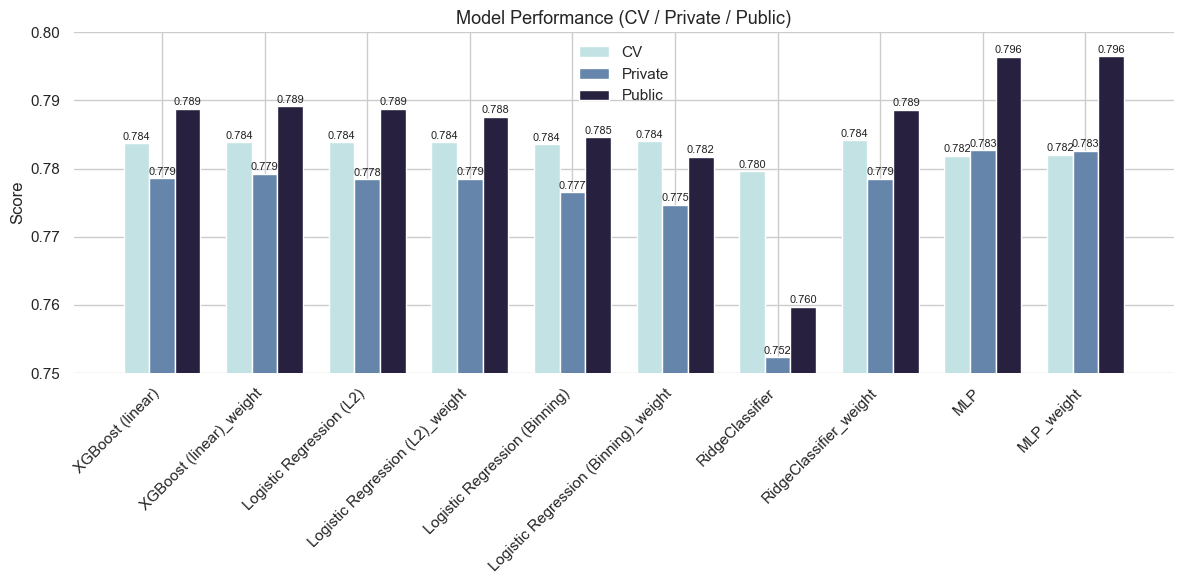

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ===== Data =====
data = {
    "Model": [
        "XGBoost (linear)",
        "XGBoost (linear)_weight",
        "Logistic Regression (L2)",
        "Logistic Regression (L2)_weight",
        "Logistic Regression (Binning)",
        "Logistic Regression (Binning)_weight",
        "RidgeClassifier",
        "RidgeClassifier_weight",
        "MLP",
        "MLP_weight",
    ],
    "CV": [
        0.783695, 0.783859, 0.783903, 0.783848,
        0.783578, 0.784064, 0.779663, 0.784184,
        0.781921, 0.782029,
    ],
    "Private Score": [
        0.77860, 0.77925, 0.77849, 0.77854,
        0.77659, 0.77470, 0.75230, 0.77855,
        0.78267, 0.78263,
    ],
    "Public Score": [
        0.78878, 0.78916, 0.78881, 0.78763,
        0.78463, 0.78176, 0.75975, 0.78865,
        0.79642, 0.79649,
    ],
}

df = pd.DataFrame(data)

# ===== Style =====
sns.set(style="whitegrid", font_scale=1.0)
colors = sns.color_palette("ch:start=.2,rot=-.3", n_colors=3)  # soft pastel ramp
x = np.arange(len(df))
width = 0.25

plt.figure(figsize=(12, 6))

# Bars
plt.bar(x - width, df["CV"], width, label="CV", color=colors[0])
plt.bar(x, df["Private Score"], width, label="Private", color=colors[1])
plt.bar(x + width, df["Public Score"], width, label="Public", color=colors[2])

# Value labels (slightly above bars)
for i in range(len(x)):
    plt.text(x[i] - width, df["CV"][i] + 0.0002, f"{df['CV'][i]:.3f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i], df["Private Score"][i] + 0.0002, f"{df['Private Score'][i]:.3f}", ha='center', va='bottom', fontsize=8)
    plt.text(x[i] + width, df["Public Score"][i] + 0.0002, f"{df['Public Score'][i]:.3f}", ha='center', va='bottom', fontsize=8)

# Axes & labels
plt.xticks(x, df["Model"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Model Performance (CV / Private / Public)", fontsize=13)
plt.legend(frameon=False)
plt.ylim(0.75, 0.80)
sns.despine(left=True, bottom=True)

# Layout & save
plt.tight_layout()
plt.savefig("model_scores_weighted.png", dpi=300)
plt.show()

### Base Model Training

Since there are 15 candidate base models, the code is relatively lengthy. To improve organization, all scripts for base model training and cross-validation are placed under the `Base_Models_Para_Optimize/` directory. Each base model script (e.g., `lgbm_para_optimize.py`) follows a standardized pipeline for model training and parameter optimization. Here are the detailed procedures for model training and cross-validation workflow.

#### 1. Data Input  
The script loads pre-processed feature datasets (`All_application_train.csv` and `All_application_test.csv`), ensuring consistent identifiers (`SK_ID_CURR`) and target variable (`TARGET`).

#### 2. Cross-Validation  
A *k-fold cross-validation* (typically 5-fold) framework is employed to estimate out-of-fold (OOF) performance.  
Each fold trains the model on \( k-1 \) subsets and validates on the remaining one, cycling through all folds.

#### 3. Hyperparameter Optimization  
Parameter tuning is automated via *Optuna* (or an equivalent Bayesian optimization library).  
The number of trials (`--n_trials`) controls how many parameter configurations are explored, and the best configuration is selected according to mean AUC across folds.

#### 4. Imbalance Handling  
The argument `--imbalance` allows different strategies such as `auto_weight`, which dynamically adjusts positive-class weights based on label distribution (e.g., ratio ≈ 11:1).

#### 5. Model Output  
After optimization, the script retrains the model using the best parameters on the full training data and saves:
- Out-of-Fold predictions (`OOF_train.csv`)
- Final test predictions (`submission.csv`)
- Log files containing parameter settings
- Feature importance results


| File Name | Corresponding Model |
| --- | --- |
| `lgbm_para_optimize.py` | LightGBM |
| `XGB_tree_para_optimize.py` | XGBoost (Tree) |
| `XGB_linear_para_optimize.py` | XGBoost (Linear) |
| `XGB_binning_para_optimize.py` | XGBoost (Feature Binning) |
| `catboost_para_optimize.py` | CatBoost |
| `HGB_para_optimize.py` | HistGradientBoosting |
| `rf_gini_para_optimize.py` | Random Forest (Gini) |
| `rf_entropy_para_optimize.py` | Random Forest (Entropy) |
| `extratree_gini_para_optimize.py` | ExtraTrees (Gini) |
| `extratree_entropy_para_optimize.py` | ExtraTrees (Entropy) |
| `LRL2_para_optimize.py` | Logistic Regression (L2) |
| `LRBin_para_optimize.py` | Logistic Regression (Binning) |
| `Ridge_classifier_para_optimize.py` | Ridge Classifier |
| `MLP_para_optimize.py` | Multilayer Perceptron (MLP) |
| `EBM_para_optimize.py` | Explainable Boosting Machine (EBM) |

Run the desired model script in a suitable environment with:

```bash
python xxx_para_optimize.py
```

Each base model's output results are stored in `Base_Models_Results`. Here we present our plotting function about their **Public Scores**.

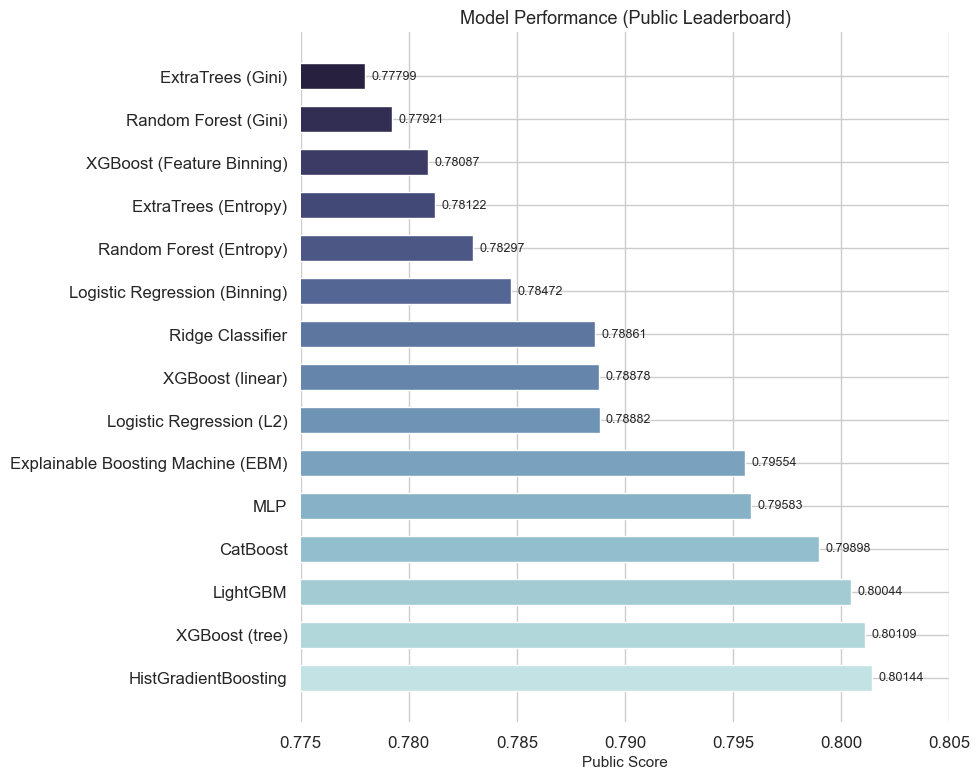

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ===== Data Preparation =====
data = {
    "Model": [
        "LightGBM",
        "XGBoost (tree)",
        "XGBoost (linear)",
        "CatBoost",
        "HistGradientBoosting",
        "XGBoost (Feature Binning)",
        "Random Forest (Gini)",
        "Random Forest (Entropy)",
        "ExtraTrees (Gini)",
        "ExtraTrees (Entropy)",
        "Logistic Regression (L2)",
        "Logistic Regression (Binning)",
        "Ridge Classifier",
        "MLP",
        "Explainable Boosting Machine (EBM)",
    ],
    "Public Score": [
        0.80044,
        0.80109,
        0.78878,
        0.79898,
        0.80144,
        0.78087,
        0.77921,
        0.78297,
        0.77799,
        0.78122,
        0.78882,
        0.78472,
        0.78861,
        0.79583,
        0.79554,
    ],
}

df = pd.DataFrame(data).sort_values("Public Score", ascending=False)

# ===== Visualization Style =====
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.figure(figsize=(10, 8))

# Use a soft, consistent color palette
colors = sns.color_palette("ch:start=.2,rot=-.3", n_colors=len(df))

bars = plt.barh(
    df["Model"],
    df["Public Score"],
    color=colors,
    edgecolor="white",
    height=0.6
)

# Display scores on the right side of bars
for bar, score in zip(bars, df["Public Score"]):
    plt.text(score + 0.0003, bar.get_y() + bar.get_height()/2,
             f"{score:.5f}", va='center', ha='left', fontsize=9)

# Beautify the plot
plt.xlabel("Public Score", fontsize=11)
plt.title("Model Performance (Public Leaderboard)", fontsize=13)
plt.xlim(0.775, 0.805)
sns.despine(left=True, bottom=True)
plt.tight_layout()

# Save and show
plt.savefig("model_public_scores.png", dpi=300)
plt.show()

## Model Ensembling

In this stage, we test and compare 5 strategies including **Blending** methods (Rank Average, Weighted Average by AUC Value, Weighted Average by AUC Quatile) and **Stacking** methods (Meta: Logistic Regression (L2), Meta: LightGBM). Here are the details and source codes.

### Rank Average

First, convert each model’s predictions into within-sample ranks, then take the average of these ranks across all models, and finally linearly map or clip the results into the range $(\epsilon, 1-\epsilon)$ to avoid extreme values of $0$ or $1$, obtaining the final blended predictions. The result is in `Ensembling_Results/submission_rankavg.csv`.

In [10]:
# --- Kaggle Submission Rank-Average Blender (Notebook Version) ---
# Run this single cell. Edit CONFIG below to your needs.

import os, glob, math
from typing import List, Dict
import numpy as np
import pandas as pd

# ========== CONFIG ==========
CONFIG = {
    # directory containing the submission CSVs
    "IN_DIR": "./Base_Models_Results",
    # glob pattern to match submission files
    "PATTERN": "baseline_*/submission_*.csv",
    "ID_COL": "SK_ID_CURR",
    "PRED_COL": "TARGET",
    "METHOD": "rank_mean",

    "WEIGHTS_CSV": None, 
    "TRIM_FRAC": 0.10,    # used by trimmed_mean
    "POWER": 1.0,         # used by power_mean / rank_power_mean
    "CLIP_PROB": True,    # clip outputs into [eps, 1-eps]
    "EPS": 1e-6,
    # merge strategy: if True, inner-join on ID; if False, outer then drop rows with any NaN
    "INNER_MERGE": False,

    # output blended submission path
    "OUT_PATH": "./submission_rankavg.csv",
}

# ========== Utilities ==========

def list_files(in_dir: str, pattern: str) -> List[str]:
    return sorted(glob.glob(os.path.join(in_dir, pattern)))

def infer_pred_column(df: pd.DataFrame, id_col: str, pred_col: str) -> str:
    if pred_col in df.columns:
        return pred_col
    # try case-insensitive
    matched = [c for c in df.columns if c.lower() == pred_col.lower()]
    if matched:
        return matched[0]
    # single non-ID column fallback
    others = [c for c in df.columns if c != id_col]
    if len(others) == 1:
        return others[0]
    raise ValueError(
        f"Cannot infer prediction column. Provided pred_col='{pred_col}' not found, "
        f"and found {len(others)} non-id columns: {others[:5]}..."
    )

def read_one_csv(path: str, id_col: str, pred_col: str):
    df = pd.read_csv(path)
    # handle id col case-insensitive
    if id_col not in df.columns:
        matched = [c for c in df.columns if c.lower() == id_col.lower()]
        if matched:
            id_col = matched[0]
        else:
            raise ValueError(f"{path}: ID column '{id_col}' not found. Available: {df.columns.tolist()}")
    pc = infer_pred_column(df, id_col, pred_col)
    out = df[[id_col, pc]].copy()
    out.columns = [id_col, "pred"]
    return out, id_col

def safe_clip_probs(x: np.ndarray, eps: float) -> np.ndarray:
    return np.clip(x, eps, 1.0 - eps)

def to_logit(p: np.ndarray, eps: float) -> np.ndarray:
    p = safe_clip_probs(p, eps)
    return np.log(p / (1.0 - p))

def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1.0 / (1.0 + np.exp(-z))

def generalized_mean(arr: np.ndarray, power: float) -> float:
    # p=1 arithmetic, p=2 RMS, p->0 geometric (limit)
    if len(arr) == 0:
        return np.nan
    if power == 0:
        eps = 1e-12
        return float(np.exp(np.mean(np.log(np.maximum(arr, eps)))))
    return float((np.mean(arr ** power)) ** (1.0 / power))

def load_weights(weights_csv: str, files: List[str]) -> np.ndarray:
    dfw = pd.read_csv(weights_csv)
    if "filename" not in dfw.columns or "weight" not in dfw.columns:
        raise ValueError("weights_csv must have columns: filename,weight")
    name2w: Dict[str, float] = {
        os.path.basename(str(r["filename"])): float(r["weight"]) for _, r in dfw.iterrows()
    }
    w = []
    for f in files:
        base = os.path.basename(f)
        if base not in name2w:
            raise ValueError(f"weights_csv missing weight for file: {base}")
        w.append(name2w[base])
    w = np.array(w, dtype=float)
    if np.any(w < 0):
        raise ValueError("weights must be non-negative")
    if not np.any(w > 0):
        raise ValueError("at least one weight must be positive")
    return w

# ========== Core Blending ==========

def blend_dataframe(stack_df: pd.DataFrame,
                    method: str,
                    weights: np.ndarray = None,
                    power: float = 1.0,
                    trim_frac: float = 0.1,
                    eps: float = 1e-6,
                    clip_prob: bool = True) -> pd.Series:
    """
    stack_df: columns are model_i predictions only (no ID)
    returns: pd.Series of blended predictions in [0,1] (unless clip disabled)
    """
    X = stack_df.values.astype(float)

    # Probability-domain methods
    if method in ("mean", "median", "trimmed_mean", "weighted_mean", "power_mean", "logit_mean"):
        if method == "mean":
            out = np.mean(X, axis=1)
        elif method == "median":
            out = np.median(X, axis=1)
        elif method == "trimmed_mean":
            if not (0.0 <= trim_frac < 0.5):
                raise ValueError("trim_frac must be in [0, 0.5).")
            k = int(np.floor(trim_frac * X.shape[1]))
            if k == 0:
                out = np.mean(X, axis=1)
            else:
                X_sorted = np.sort(X, axis=1)
                out = np.mean(X_sorted[:, k: X.shape[1]-k], axis=1)
        elif method == "weighted_mean":
            if weights is None:
                raise ValueError("weights required for weighted_mean")
            w = np.array(weights, dtype=float)
            w = w / np.sum(w)
            out = np.dot(X, w)
        elif method == "power_mean":
            if np.any(X < 0):
                raise ValueError("power_mean requires non-negative predictions")
            out = np.array([generalized_mean(row, power) for row in X])
        elif method == "logit_mean":
            Z = np.apply_along_axis(lambda col: to_logit(col, eps), 0, X)  # column-wise logit
            out = sigmoid(np.mean(Z, axis=1))
        if clip_prob:
            out = safe_clip_probs(out, eps)
        return pd.Series(out, index=stack_df.index)

    # Rank-based methods
    if method not in ("rank_mean", "rank_median", "rank_weighted_mean", "rank_power_mean"):
        raise ValueError(f"Unknown method: {method}")

    # Rank normalization per column into [0,1]
    X_rank = np.zeros_like(X)
    for j in range(X.shape[1]):
        X_rank[:, j] = pd.Series(X[:, j]).rank(method="average", pct=True).to_numpy()

    if method == "rank_mean":
        out = np.mean(X_rank, axis=1)
    elif method == "rank_median":
        out = np.median(X_rank, axis=1)
    elif method == "rank_weighted_mean":
        if weights is None:
            raise ValueError("weights required for rank_weighted_mean")
        w = np.array(weights, dtype=float)
        w = w / np.sum(w)
        out = np.dot(X_rank, w)
    elif method == "rank_power_mean":
        if np.any(X_rank < 0):
            raise ValueError("rank_power_mean requires non-negative ranks (should never happen).")
        out = np.array([generalized_mean(row, power) for row in X_rank])

    if clip_prob:
        out = safe_clip_probs(out, eps)
    return pd.Series(out, index=stack_df.index)

# ========== Runner (Notebook) ==========

def run_blend(config: dict) -> pd.DataFrame:
    in_dir     = config["IN_DIR"]
    pattern    = config["PATTERN"]
    id_col     = config["ID_COL"]
    pred_col   = config["PRED_COL"]
    method     = config["METHOD"]
    weights_csv= config["WEIGHTS_CSV"]
    trim_frac  = config["TRIM_FRAC"]
    power      = config["POWER"]
    clip_prob  = config["CLIP_PROB"]
    eps        = config["EPS"]
    inner_merge= config["INNER_MERGE"]
    out_path   = config["OUT_PATH"]

    files = list_files(in_dir, pattern)
    if len(files) == 0:
        raise FileNotFoundError(f"No files matched pattern: {os.path.join(in_dir, pattern)}")

    print(f"[Info] Found {len(files)} files")
    for i, f in enumerate(files, 1):
        print(f"  [{i:02d}] {f}")

    # Read all submission files -> merge on ID
    dfs = []
    id_col_final = id_col
    for f in files:
        d, id_col_final = read_one_csv(f, id_col, pred_col)
        d = d.rename(columns={"pred": os.path.basename(f)})
        dfs.append(d)

    if inner_merge:
        base = dfs[0]
        for d in dfs[1:]:
            base = base.merge(d, on=id_col_final, how="inner")
    else:
        base = dfs[0]
        for d in dfs[1:]:
            base = base.merge(d, on=id_col_final, how="outer")
        before = len(base)
        base = base.dropna()
        after = len(base)
        if before != after:
            print(f"[Warn] Dropped {before - after} rows due to missing id/pred after outer merge.")

    base = base.set_index(id_col_final)
    stack_df = base.copy()

    # Prepare weights if needed
    weights = None
    if method in ("weighted_mean", "rank_weighted_mean"):
        if weights_csv is None:
            raise ValueError(f"{method} requires CONFIG['WEIGHTS_CSV'] to be set.")
        weights = load_weights(weights_csv, files)

    # Blend
    blended = blend_dataframe(
        stack_df=stack_df,
        method=method,
        weights=weights,
        power=power,
        trim_frac=trim_frac,
        eps=eps,
        clip_prob=clip_prob
    )

    # Save to CSV
    out = pd.DataFrame({id_col_final: blended.index, pred_col: blended.values})
    out.to_csv(out_path, index=False)
    print(f"[Done] Wrote blended submission -> {out_path}")

    # Show a quick preview
    display(out.head())
    return out

# Execute
_ = run_blend(CONFIG)

[Info] Found 11 files
  [01] ./Base_Models_Results/baseline_catboost/submission_20251011_172106.csv
  [02] ./Base_Models_Results/baseline_ebm/submission_20251012_124701.csv
  [03] ./Base_Models_Results/baseline_extratrees_entropy_grid/submission_20251011_231445.csv
  [04] ./Base_Models_Results/baseline_hgbc_grid/submission_20251011_230429.csv
  [05] ./Base_Models_Results/baseline_lgbm/submission_20251010_210539.csv
  [06] ./Base_Models_Results/baseline_logreg_bin_grid/submission_20251012_094836.csv
  [07] ./Base_Models_Results/baseline_logreg_l2_grid/submission_20251012_081959.csv
  [08] ./Base_Models_Results/baseline_mlp_grid/submission_20251011_171055.csv
  [09] ./Base_Models_Results/baseline_rf_entropy_grid/submission_20251011_231553.csv
  [10] ./Base_Models_Results/baseline_xgb_binning_grid/submission_20251011_192828.csv
  [11] ./Base_Models_Results/baseline_xgb_tree_grid/submission_20251011_183432.csv
[Done] Wrote blended submission -> ./submission_rankavg.csv


,SK_ID_CURR,TARGET
0,100001,0.514456
1,100005,0.851139
2,100013,0.540443
3,100028,0.387762
4,100038,0.892878


### Weighted Average by AUC Value & Weighted Average by AUC Quantile

- **Weighted Average by AUC Value:** Unlike *Rank Average*, where all base models are treated equally, this method assigns each base model $i$ a weight proportional $w_i=\frac{\text{AUC}_i}{\sum_{k=1}^{11} \text{AUC}_i}$ to its AUC value. 
- **Weighted Average by AUC Quantile:** Each model’s $\text{AUC}_i$ is mapped to a quantile value $Q_i=\text{rank} (\text{AUC}_i)/11$. The weights are then assigned according to these quantile-based ratios $w_i=\frac{Q_i}{\sum_{k=1}^{11} Q_i}$, which suppress the over-amplification of extreme AUC values. 

The results are in `Ensembling_Results/submission_blend_prob.csv` (Weighted Average by AUC Value) and `Ensembling_Results/submission_blend_rank.csv` (Weighted Average by AUC Quantile).

In [14]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Home Credit - One-Click Blend Launcher
======================================

A one-click blending tool that runs directly without command-line arguments.
It automatically merges all submission_*.csv files under Baseline/**/
and produces the following outputs:
  - submission_blend_prob.csv
  - submission_blend_rank.csv
  - submission_blend_report.csv
"""

import os
import json
import glob
import numpy as np
import pandas as pd
from datetime import datetime

# ========== One-Click Configuration ==========
BASE_DIR    = "Base_Models_Results"
PATTERN     = "**/submission_*.csv"
ID_COL      = "SK_ID_CURR"
PRED_COL    = "TARGET"
MODE        = "both"      # Options: "prob" / "rank" / "both"
OUT_PREFIX  = f"submission_blend"
WEIGHTS_CSV = "weights.csv"   # Set to None if not available

# ========== Manual Weights (fallback option) ==========
weights_manual = {
    "baseline_lgbm": 0.79509,
    "baseline_xgb_tree_grid": 0.79678,
    "baseline_catboost": 0.79500,
    "baseline_hgbc_grid": 0.79568,
    "baseline_xgb_binning_grid": 0.78360,
    "baseline_rf_entropy_grid": 0.77443,
    "baseline_logreg_l2_grid": 0.77850,
    "baseline_logreg_bin_grid": 0.77665,
    "baseline_ridge_calibrated_grid": 0.77850,
    "baseline_mlp_grid": 0.78270,
    "baseline_ebm": 0.78889,
}

# ========== Utility Functions ==========
def find_submissions(base_dir, pattern):
    paths = sorted(glob.glob(os.path.join(base_dir, pattern), recursive=True))
    return [(os.path.basename(os.path.dirname(p)), p) for p in paths]

def load_weights_from_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.columns = [c.lower() for c in df.columns]
    if "key" not in df.columns:
        raise ValueError("weights_csv must contain: key + (weight/local_auc/public_lb)")
    if "weight" in df.columns:
        col = "weight"
    elif "local_auc" in df.columns:
        col = "local_auc"
    elif "public_lb" in df.columns:
        col = "public_lb"
    else:
        raise ValueError("weights_csv missing 'weight', 'local_auc', or 'public_lb' column")
    return df.set_index("key")[col].astype(float).to_dict()

def normalize_weights(wdict):
    arr = np.array(list(wdict.values()), dtype=float)
    arr = arr / arr.sum()
    return {k: float(v) for k, v in zip(wdict.keys(), arr)}

# ========== Main Blending Pipeline ==========
def run_blend():
    items = find_submissions(BASE_DIR, PATTERN)
    if not items:
        raise FileNotFoundError(f"No matching files found: {BASE_DIR}/{PATTERN}")

    print(f"[Info] Found {len(items)} submissions:")
    for k, p in items:
        print(f"  - {k}: {p}")

    merged = None
    pred_cols, keys = [], []
    for key, path in items:
        df = pd.read_csv(path)
        df = df[[ID_COL, PRED_COL]].rename(columns={PRED_COL: f"pred__{key}"})
        merged = df if merged is None else merged.merge(df, on=ID_COL, how="inner")
        pred_cols.append(f"pred__{key}")
        keys.append(key)

    # Load weights
    if WEIGHTS_CSV and os.path.exists(WEIGHTS_CSV):
        weights = load_weights_from_csv(WEIGHTS_CSV)
        src = "csv"
    elif weights_manual:
        weights = weights_manual
        src = "manual"
    else:
        weights = {k: 1.0 for k in keys}
        src = "equal"
    weights = {k: weights.get(k, 1.0) for k in keys}
    weights = normalize_weights(weights)

    print(f"[Info] Weight source: {src}")
    print(f"[Info] Normalized weights: {[round(weights[k],4) for k in keys]}")

    prob = merged[pred_cols].clip(0, 1)
    w_vec = np.array([weights[k] for k in keys])

    # ===== Probability-domain blending =====
    if MODE in ("prob", "both"):
        out_prob = f"{OUT_PREFIX}_prob.csv"
        merged[[ID_COL]].assign(
            **{PRED_COL: np.average(prob.values, axis=1, weights=w_vec)}
        ).to_csv(out_prob, index=False)
        print(f"[Done] Probability blend saved: {out_prob}")

    # ===== Rank-domain blending =====
    if MODE in ("rank", "both"):
        out_rank = f"{OUT_PREFIX}_rank.csv"
        rank = prob.rank(pct=True)
        merged[[ID_COL]].assign(
            **{PRED_COL: np.average(rank.values, axis=1, weights=w_vec)}
        ).to_csv(out_rank, index=False)
        print(f"[Done] Rank blend saved: {out_rank}")

    # ===== Report generation =====
    corr = prob.rank(pct=True).corr("spearman")
    rep = pd.DataFrame({
        "key": keys,
        "weight": [weights[k] for k in keys],
        "mean_pred": prob.mean(0).values,
        "std_pred": prob.std(0).values,
        "avg_spearman": [
            (corr[c].sum() - 1) / max(len(pred_cols) - 1, 1) for c in corr.columns
        ],
    })
    out_rep = f"{OUT_PREFIX}_report.csv"
    rep.to_csv(out_rep, index=False)
    print(f"[Done] Report saved: {out_rep}")

    print("\n=== Blend Summary ===")
    print(f"Models      : {len(keys)}")
    print(f"Weight src  : {src}")
    print(f"Output base : {OUT_PREFIX}")
    print(f"Files       : prob / rank / report")

# ========== Entry Point ==========
if __name__ == "__main__":
    run_blend()


[Info] Found 11 submissions:
  - baseline_catboost: Base_Models_Results/baseline_catboost/submission_20251011_172106.csv
  - baseline_ebm: Base_Models_Results/baseline_ebm/submission_20251012_124701.csv
  - baseline_extratrees_entropy_grid: Base_Models_Results/baseline_extratrees_entropy_grid/submission_20251011_231445.csv
  - baseline_hgbc_grid: Base_Models_Results/baseline_hgbc_grid/submission_20251011_230429.csv
  - baseline_lgbm: Base_Models_Results/baseline_lgbm/submission_20251010_210539.csv
  - baseline_logreg_bin_grid: Base_Models_Results/baseline_logreg_bin_grid/submission_20251012_094836.csv
  - baseline_logreg_l2_grid: Base_Models_Results/baseline_logreg_l2_grid/submission_20251012_081959.csv
  - baseline_mlp_grid: Base_Models_Results/baseline_mlp_grid/submission_20251011_171055.csv
  - baseline_rf_entropy_grid: Base_Models_Results/baseline_rf_entropy_grid/submission_20251011_231553.csv
  - baseline_xgb_binning_grid: Base_Models_Results/baseline_xgb_binning_grid/submission_2

### Meta: Logistic Regression (L2)

Concatenate the out-of-fold (OOF) predictions from all base models to form a second-level feature matrix, and then use a meta-learner — Logistic Regression (L2) — to maximize the AUC. The result is in `Ensembling_Results/submission_meta_logreg.csv`.

In [17]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Simple Meta-Learner (OOF includes TARGET)
=========================================

Requirements:
  Each base model directory must contain:
    - oof_*.csv          (with columns: SK_ID_CURR, oof_pred, TARGET)
    - submission_*.csv   (with columns: SK_ID_CURR, TARGET)
"""

import os, glob, json, warnings
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, Ridge

warnings.filterwarnings("ignore")

# ========== Configuration ==========
ROOT_DIR = "./Base_Models_Results"        # Root directory containing base model folders
OUT_DIR  = "."   # Output directory
META     = "logreg"            # "logreg" | "ridge"
N_SPLITS = 5
SEED     = 42
CLIP     = (0.0001, 0.9999)

os.makedirs(OUT_DIR, exist_ok=True)

# ========== Step 1: Collect all OOF and submission files ==========
model_names, oof_list, sub_list = [], [], []

for subdir in sorted(os.listdir(ROOT_DIR)):
    path = os.path.join(ROOT_DIR, subdir)
    if not os.path.isdir(path):
        continue

    oof_files = sorted(glob.glob(os.path.join(path, "oof_*.csv")))
    sub_files = sorted(glob.glob(os.path.join(path, "submission_*.csv")))
    if not oof_files or not sub_files:
        continue

    oof_path = oof_files[-1]
    sub_path = sub_files[-1]

    oof_df = pd.read_csv(oof_path)
    sub_df = pd.read_csv(sub_path)

    # Check required columns
    assert "SK_ID_CURR" in oof_df.columns
    assert "TARGET" in oof_df.columns

    pred_col = [c for c in oof_df.columns if c not in ["SK_ID_CURR", "TARGET"]][0]
    oof_df = oof_df[["SK_ID_CURR", "TARGET", pred_col]].rename(columns={pred_col: subdir})
    sub_df = sub_df.rename(columns={sub_df.columns[-1]: subdir})  # prediction column

    oof_list.append(oof_df.set_index("SK_ID_CURR")[subdir])
    sub_list.append(sub_df.set_index("SK_ID_CURR")[subdir])
    model_names.append(subdir)

assert len(model_names) >= 2, "At least two models are required."

print(f"Found models: {model_names}")

# ========== Step 2: Build training and test matrices ==========
oof_mat = pd.concat(oof_list, axis=1, join="inner")
sub_mat = pd.concat(sub_list, axis=1, join="inner")

# Extract TARGET (should be consistent across all OOFs)
y = pd.read_csv(oof_files[-1])["TARGET"]
y = y[:len(oof_mat)].values.astype(int)

X_oof = oof_mat.values
X_test = sub_mat.values

if CLIP:
    X_oof = np.clip(X_oof, *CLIP)
    X_test = np.clip(X_test, *CLIP)

# ========== Step 3: Second-level CV training ==========
kf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
oof_pred = np.zeros_like(y, dtype=float)
test_pred_folds = []

for fold, (trn_idx, val_idx) in enumerate(kf.split(X_oof, y), 1):
    X_tr, y_tr = X_oof[trn_idx], y[trn_idx]
    X_va, y_va = X_oof[val_idx], y[val_idx]

    if META == "logreg":
        model = LogisticRegression(max_iter=1000)
    else:
        model = Ridge(alpha=1.0, random_state=SEED)

    model.fit(X_tr, y_tr)
    val_pred = model.predict_proba(X_va)[:, 1] if META == "logreg" else model.predict(X_va)
    tst_pred = model.predict_proba(X_test)[:, 1] if META == "logreg" else model.predict(X_test)

    oof_pred[val_idx] = val_pred
    test_pred_folds.append(tst_pred)

    print(f"[Fold {fold}] AUC = {roc_auc_score(y_va, val_pred):.6f}")

meta_test = np.mean(test_pred_folds, axis=0)
meta_auc = roc_auc_score(y, oof_pred)
print(f"\n==== Meta OOF AUC = {meta_auc:.6f} ====\n")

# ========== Step 4: Export results ==========
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_prefix = os.path.join(OUT_DIR, f"submission_meta_{META}")

# Save OOF predictions
pd.DataFrame({
    "SK_ID_CURR": oof_mat.index,
    "TARGET": y,
    "PRED": oof_pred
}).to_csv(f"{out_prefix}_oof.csv", index=False)

# Save test submission
pd.DataFrame({
    "SK_ID_CURR": sub_mat.index,
    "TARGET": meta_test
}).to_csv(f"{out_prefix}.csv", index=False)

# Save metadata report
report = {
    "models": model_names,
    "meta": META,
    "oof_auc": meta_auc,
    "timestamp": timestamp
}
with open(f"{out_prefix}_report.json", "w") as f:
    json.dump(report, f, indent=2)

print(f"Saved:\n  {out_prefix}.csv\n  {out_prefix}_oof.csv\n  {out_prefix}_report.json")


Found models: ['baseline_catboost', 'baseline_ebm', 'baseline_extratrees_entropy_grid', 'baseline_hgbc_grid', 'baseline_lgbm', 'baseline_logreg_bin_grid', 'baseline_logreg_l2_grid', 'baseline_mlp_grid', 'baseline_rf_entropy_grid', 'baseline_xgb_binning_grid', 'baseline_xgb_tree_grid']
[Fold 1] AUC = 0.789234
[Fold 2] AUC = 0.798785
[Fold 3] AUC = 0.789662
[Fold 4] AUC = 0.796863
[Fold 5] AUC = 0.791284

==== Meta OOF AUC = 0.793114 ====

Saved:
  ./submission_meta_logreg.csv
  ./submission_meta_logreg_oof.csv
  ./submission_meta_logreg_report.json


### Meta: LightGBM

Same as **Meta: Logistic Regression (L2)**, but the meta-learner is replaced with LightGBM. The result is in `Ensembling_Results/submission_meta_lgbm.csv`.

In [19]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
LightGBM Meta-Learner (OOF includes TARGET)
===========================================
Directory structure example:
Baseline/
  baseline_catboost/
    oof_xxx.csv        # Columns: SK_ID_CURR, oof_pred, TARGET
    submission_xxx.csv # Columns: SK_ID_CURR, <any probability column>
  baseline_lgbm/
    oof_xxx.csv
    submission_xxx.csv
  ...

Output:
Baseline_meta/
  submission_meta_lgbm.csv
  lgbm_meta_YYYYmmdd_HHMMSS_oof.csv
  lgbm_meta_YYYYmmdd_HHMMSS_feature_importance.csv
  lgbm_meta_YYYYmmdd_HHMMSS_report.json
"""

import os, glob, json, warnings
from datetime import datetime

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")

# ======== Configuration ========
ROOT_DIR   = "./Base_Models_Results"        # Root directory of base models
OUT_DIR    = "."   # Output directory
N_SPLITS   = 5
SEED       = 42
CLIP       = (0.0001, 0.9999)    # Clip extreme values; set to None to disable
USE_LOGIT  = False               # Optionally add logit-transformed features

LGB_PARAMS = dict(
    objective="binary",
    metric="auc",
    learning_rate=0.03,
    num_leaves=15,
    max_depth=-1,
    min_data_in_leaf=10,
    feature_fraction=1,
    bagging_fraction=0.8,
    bagging_freq=1,
    lambda_l1=0.0,
    lambda_l2=1.0,
    verbose=-1,
    seed=SEED,
)

NUM_BOOST_ROUND = 2000
EARLY_STOP_ROUNDS = 200
# ================================


def _safe_last_pred_col(df, forbid=("SK_ID_CURR", "TARGET")):
    cands = [c for c in df.columns if c not in forbid]
    if not cands:
        raise ValueError("No prediction column found. Please check the CSV file.")
    # Prefer common column names
    for k in ["PRED", "prob", "prediction", "TARGET"]:
        if k in cands:
            return k
    # Otherwise, return the last numeric column
    num = [c for c in cands if pd.api.types.is_numeric_dtype(df[c])]
    return num[-1] if num else cands[-1]


def _logit(p, eps=1e-6):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))


def main():
    import lightgbm as lgb

    os.makedirs(OUT_DIR, exist_ok=True)

    # 1) Collect OOF and submission files from base models
    model_names, oof_series, sub_series = [], [], []
    for subdir in sorted(os.listdir(ROOT_DIR)):
        p = os.path.join(ROOT_DIR, subdir)
        if not os.path.isdir(p):
            continue
        oof_files = sorted(glob.glob(os.path.join(p, "oof_*.csv")))
        sub_files = sorted(glob.glob(os.path.join(p, "submission_*.csv")))
        if not oof_files or not sub_files:
            continue

        oof_df = pd.read_csv(oof_files[-1])
        sub_df = pd.read_csv(sub_files[-1])

        assert "SK_ID_CURR" in oof_df.columns and "TARGET" in oof_df.columns, \
            f"OOF file in {subdir} must contain SK_ID_CURR and TARGET columns."

        pred_oof = _safe_last_pred_col(oof_df)
        pred_sub = _safe_last_pred_col(sub_df, forbid=("SK_ID_CURR",))

        oof_series.append(
            oof_df.set_index("SK_ID_CURR")[[pred_oof, "TARGET"]].rename(columns={pred_oof: subdir})
        )
        sub_series.append(
            sub_df.set_index("SK_ID_CURR")[[pred_sub]].rename(columns={pred_sub: subdir})
        )
        model_names.append(subdir)

    if len(model_names) < 2:
        raise RuntimeError("At least two valid base models are required.")

    # 2) Assemble training and test matrices (inner join to align IDs)
    oof_df_all = None
    for s in oof_series:
        if oof_df_all is None:
            oof_df_all = s.copy()
        else:
            oof_df_all = oof_df_all.join(s[[s.columns[0]]], how="inner")

    y = oof_series[0]["TARGET"].reindex(oof_df_all.index).astype(int).values
    X_oof = oof_df_all[model_names].values

    sub_mat = pd.concat(sub_series, axis=1, join="inner")
    X_test = sub_mat[model_names].values

    # Optional clipping and logit transformation
    if CLIP:
        X_oof = np.clip(X_oof, *CLIP)
        X_test = np.clip(X_test, *CLIP)
    if USE_LOGIT:
        X_oof = np.hstack([X_oof, _logit(X_oof)])
        X_test = np.hstack([X_test, _logit(X_test)])
        model_feat_names = [*(f"{m}" for m in model_names), *(f"{m}_logit" for m in model_names)]
    else:
        model_feat_names = model_names

    # 3) Second-level LightGBM training with Stratified K-Fold CV
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
    oof_pred = np.zeros(len(y), dtype=float)
    test_pred_folds = []
    imp_accum = np.zeros(len(model_feat_names), dtype=float)
    fold_scores = []

    for fold, (tr, va) in enumerate(skf.split(X_oof, y), 1):
        X_tr, y_tr = X_oof[tr], y[tr]
        X_va, y_va = X_oof[va], y[va]

        dtr = lgb.Dataset(X_tr, label=y_tr, feature_name=model_feat_names, free_raw_data=False)
        dva = lgb.Dataset(X_va, label=y_va, reference=dtr, feature_name=model_feat_names, free_raw_data=False)

        booster = lgb.train(
            params=LGB_PARAMS,
            train_set=dtr,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[dtr, dva],
            valid_names=["train", "valid"],
            callbacks=[
                lgb.early_stopping(EARLY_STOP_ROUNDS, verbose=False),
                lgb.log_evaluation(period=100)
            ],
        )

        val = booster.predict(X_va, num_iteration=booster.best_iteration)
        tst = booster.predict(X_test, num_iteration=booster.best_iteration)

        oof_pred[va] = val
        test_pred_folds.append(tst)
        fold_auc = roc_auc_score(y_va, val)
        fold_scores.append(float(fold_auc))

        imp = booster.feature_importance(importance_type="gain")
        imp_accum += imp

        print(f"[Fold {fold}] best_iter={int(booster.best_iteration)}  AUC={fold_auc:.6f}")

    meta_auc = roc_auc_score(y, oof_pred)
    test_pred = np.mean(test_pred_folds, axis=0)

    # 4) Save outputs
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    prefix = os.path.join(OUT_DIR, f"lgbm_meta_{ts}")

    # Fixed submission name
    sub_out = pd.DataFrame({"SK_ID_CURR": sub_mat.index, "TARGET": test_pred})
    sub_path = os.path.join(OUT_DIR, "submission_meta_lgbm.csv")
    sub_out.to_csv(sub_path, index=False)

    # OOF
    oof_out = pd.DataFrame({"SK_ID_CURR": oof_df_all.index, "TARGET": y, "PRED": oof_pred})
    oof_out.to_csv(prefix + "_oof.csv", index=False)

    # Feature importance
    imp_df = pd.DataFrame({
        "feature": model_feat_names,
        "gain": imp_accum / N_SPLITS
    }).sort_values("gain", ascending=False)
    imp_df.to_csv(prefix + "_feature_importance.csv", index=False)

    # Report
    report = {
        "models": model_names,
        "use_logit": USE_LOGIT,
        "params": LGB_PARAMS,
        "n_splits": N_SPLITS,
        "seed": SEED,
        "clip": CLIP,
        "num_boost_round": NUM_BOOST_ROUND,
        "early_stopping_rounds": EARLY_STOP_ROUNDS,
        "fold_auc": fold_scores,
        "oof_auc": float(meta_auc),
        "timestamp": ts,
    }
    with open(prefix + "_report.json", "w") as f:
        json.dump(report, f, indent=2)

    print("\n==== LightGBM Meta-Learner Completed ====")
    print(f"OOF AUC : {meta_auc:.6f}")
    print("Saved:")
    print(" ", sub_path)
    print(" ", prefix + "_oof.csv")
    print(" ", prefix + "_feature_importance.csv")
    print(" ", prefix + "_report.json")


if __name__ == "__main__":
    main()

[100]	train's auc: 0.805338	valid's auc: 0.797138
[200]	train's auc: 0.808831	valid's auc: 0.797401
[300]	train's auc: 0.811512	valid's auc: 0.797407
[400]	train's auc: 0.814192	valid's auc: 0.797274
[Fold 1] best_iter=286  AUC=0.797457
[100]	train's auc: 0.803171	valid's auc: 0.806956
[200]	train's auc: 0.806354	valid's auc: 0.806767
[300]	train's auc: 0.809368	valid's auc: 0.806841
[Fold 2] best_iter=105  AUC=0.806963
[100]	train's auc: 0.805523	valid's auc: 0.796626
[200]	train's auc: 0.808984	valid's auc: 0.796592
[300]	train's auc: 0.811632	valid's auc: 0.796596
[Fold 3] best_iter=104  AUC=0.796665
[100]	train's auc: 0.803837	valid's auc: 0.80346
[200]	train's auc: 0.807162	valid's auc: 0.803456
[300]	train's auc: 0.810175	valid's auc: 0.803399
[Fold 4] best_iter=136  AUC=0.803568
[100]	train's auc: 0.80528	valid's auc: 0.797081
[200]	train's auc: 0.808783	valid's auc: 0.79713
[300]	train's auc: 0.811648	valid's auc: 0.797055
[Fold 5] best_iter=173  AUC=0.797219

==== LightGBM Met

### Visualization of the ensembling step

Below we plot 
- The Public Scores and Private Scores
- Spearman correlation coefficient matrix

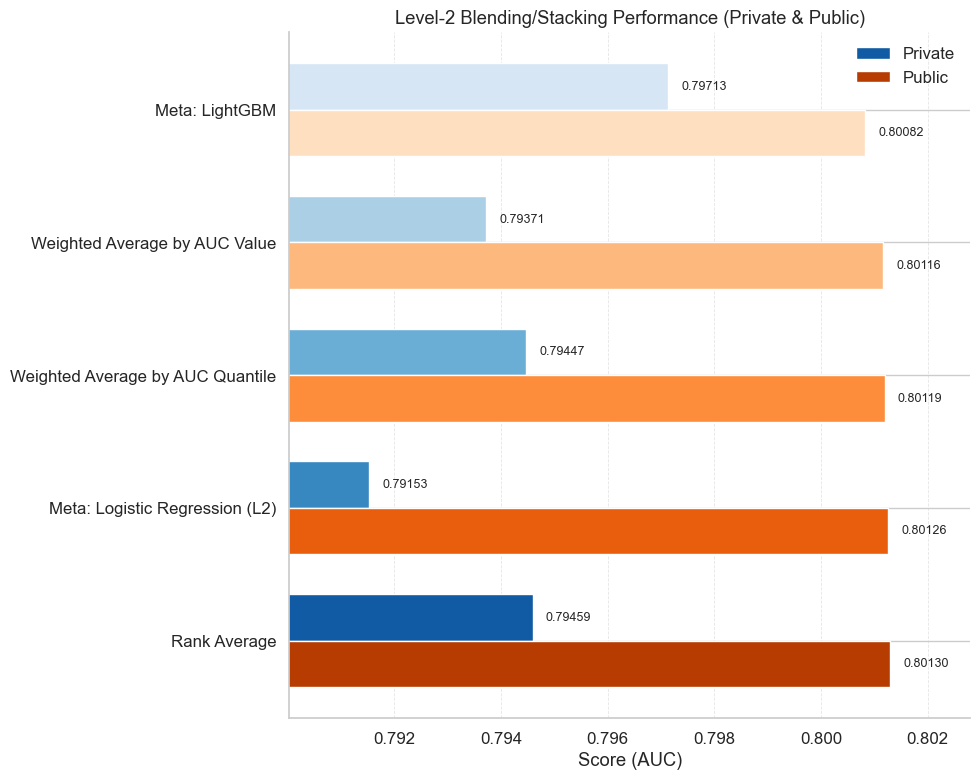

In [21]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns  # used only to obtain soft gradient palettes

# ========== Optional: CJK fonts (enable one according to your system) ==========
# import matplotlib
# matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK SC', 'PingFang SC', 'SimHei', 'Arial Unicode MS']
# matplotlib.rcParams['axes.unicode_minus'] = False

# ========== Data ==========
records = [
    {"Method": "Rank Average",                          "Private": 0.79459, "Public": 0.80130},
    {"Method": "Weighted Average by AUC Value",         "Private": 0.79371, "Public": 0.80116},
    {"Method": "Weighted Average by AUC Quantile",      "Private": 0.79447, "Public": 0.80119},
    {"Method": "Meta: Logistic Regression (L2)",        "Private": 0.79153, "Public": 0.80126},
    {"Method": "Meta: LightGBM",                        "Private": 0.79713, "Public": 0.80082},
]
df = pd.DataFrame(records).sort_values("Public", ascending=False).reset_index(drop=True)

# ========== Color palettes (soft gradients: Private = blue, Public = orange) ==========
n = len(df)
cool_palette = sns.color_palette("Blues", n)    # for Private
warm_palette = sns.color_palette("Oranges", n)  # for Public
# Make higher scores appear “stronger”: reverse after sorting
cool_colors = list(reversed(cool_palette))
warm_colors = list(reversed(warm_palette))

# ========== Plot ==========
plt.figure(figsize=(10, 8.0))

y = np.arange(n)
h = 0.35  # bar thickness

# Two horizontal bars per method (Private above, Public below)
bars_private = plt.barh(y + h/2, df["Private"], height=h, label="Private",
                        color=cool_colors, edgecolor="white")
bars_public  = plt.barh(y - h/2, df["Public"],  height=h, label="Public",
                        color=warm_colors, edgecolor="white")

plt.yticks(y, df["Method"])
plt.xlabel("Score (AUC)")
plt.title("Level-2 Blending/Stacking Performance (Private & Public)")

# Value labels
def annotate(bars, values):
    for b, v in zip(bars, values):
        plt.text(b.get_width() + 0.00025, b.get_y() + b.get_height()/2,
                 f"{v:.5f}", va="center", ha="left", fontsize=9)
annotate(bars_private, df["Private"])
annotate(bars_public,  df["Public"])

# Axis range and grid
xmin = float(min(df["Private"].min(), df["Public"].min()))
xmax = float(max(df["Private"].max(), df["Public"].max()))
pad = 0.0015
plt.xlim(xmin - pad, xmax + pad)
plt.grid(axis="x", linestyle="--", linewidth=0.6, alpha=0.5)

# Remove top/right spines & show legend
ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
plt.legend(loc="upper right", frameon=False)

plt.tight_layout()
plt.savefig("level2_private_public_barh_soft.png", dpi=300, bbox_inches="tight")
plt.show()


[INFO] Found 5 submission files:
  - submission_blend_prob.csv
  - submission_blend_rank.csv
  - submission_meta_lgbm.csv
  - submission_meta_logreg.csv
  - submission_rankavg.csv
[OK] Correlation matrix saved to -> ./Ensembling_Results/level2_corr_matrix.csv


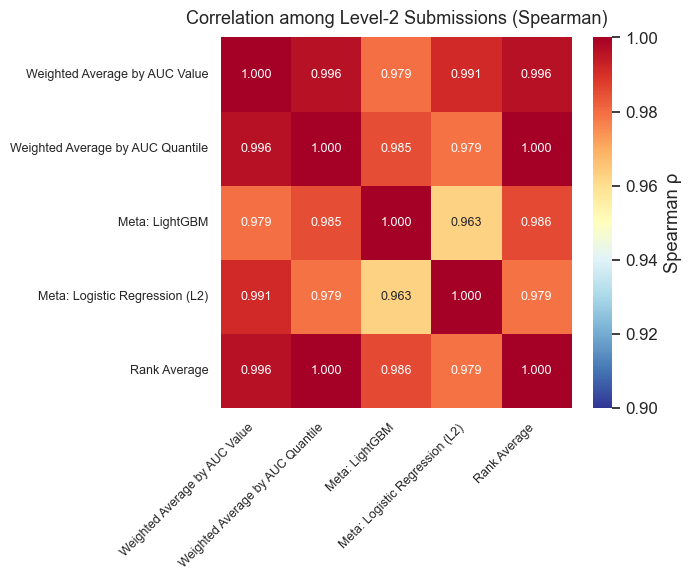

[OK] Heatmap saved to -> ./Ensembling_Results/level2_corr_heatmap.png


In [26]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Home Credit - Level-2 Model Correlation Analysis
================================================
Reads submission_*.csv files from level2_model/,
computes the Spearman correlation matrix, and visualizes it as a heatmap.
"""

import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# ===== Configuration =====
BASE_DIR = "./Ensembling_Results"
PATTERN = "submission_*.csv"
ID_COL = "SK_ID_CURR"
PRED_COL = "TARGET"

# ===== File name mapping =====
rename_map = {
    "submission_blend_prob": "Weighted Average by AUC Value",
    "submission_blend_rank": "Weighted Average by AUC Quantile",
    "submission_meta_lgbm": "Meta: LightGBM",
    "submission_meta_logreg": "Meta: Logistic Regression (L2)",
    "submission_rankavg": "Rank Average",
}

# ===== Read all submissions =====
paths = sorted(glob.glob(os.path.join(BASE_DIR, PATTERN)))
print(f"[INFO] Found {len(paths)} submission files:")
for p in paths:
    print("  -", os.path.basename(p))
if len(paths) < 2:
    raise RuntimeError("At least two submission files are required. Please check the path.")

dfs = []
for p in paths:
    df = pd.read_csv(p, usecols=[ID_COL, PRED_COL])
    name = os.path.splitext(os.path.basename(p))[0]
    name = rename_map.get(name, name)  # rename if found in map
    dfs.append(df.rename(columns={PRED_COL: name}))

merged = dfs[0]
for d in dfs[1:]:
    merged = merged.merge(d, on=ID_COL, how="inner")
pred_df = merged.drop(columns=[ID_COL])

# ===== Compute Spearman correlation matrix =====
corr_matrix = pred_df.corr(method="spearman")
corr_path = os.path.join(BASE_DIR, "level2_corr_matrix.csv")
corr_matrix.to_csv(corr_path, float_format="%.6f")
print(f"[OK] Correlation matrix saved to -> {corr_path}")

# ===== Plot heatmap =====
plt.figure(figsize=(7, 6))
sns.heatmap(
    corr_matrix,
    cmap=plt.cm.RdYlBu_r,
    vmin=0.90, vmax=1.00,
    annot=True, fmt=".3f",
    annot_kws={"size": 9},
    cbar_kws={"label": "Spearman ρ"}
)
plt.title("Correlation among Level-2 Submissions (Spearman)", fontsize=13, pad=10)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
out_path = os.path.join(BASE_DIR, "level2_corr_heatmap.png")
plt.savefig(out_path, dpi=300)
plt.show()
print(f"[OK] Heatmap saved to -> {out_path}")


## Final Model Blender (RankAvg + Meta-LGBM)

Based on the AUC performance and correlation analysis, we infer that the advantage of each individual approach may mainly lie in the reordering of marginal samples. Therefore, to preserve overall robustness while leveraging the local strengths of different methods, we further constructed a weighted blending scheme:

$$
\hat{y}=\alpha \hat{y}_{\text{RankAvg}}+(1-\alpha)\hat{y}_{\text{Metalgbm}}
$$

where $\hat{y}$ denotes the predicted value and $\alpha=0.5$.
The final results achieved a Private Score of 0.79582 and a Public Score of 0.80181.
Overall, this weighted blending approach effectively balances the strengths and weaknesses of different models, further enhancing generalization performance. The Public Score improved by 0.00051, demonstrating a well-balanced trade-off between performance and stability. Our final result is `Final_submission.csv`.

[Load] Reading Features/All_application_train.csv and Features/All_application_test.csv ...
[Load] train: (307511, 773), test: (48744, 772)

[Stage 0] Auditing and cleaning ...
[Stage 0] Checking duplicate columns by content hash ...
[Stage 0] Audit saved: feature_audit.csv; proposed dropping 113 columns
[Stage 0] Dropping 113 columns, first few: ['AMT_ANNUITY_y', 'AMT_CREDIT_y', 'AMT_GOODS_PRICE_y', 'AMT_INCOME_TOTAL_y', 'AMT_REQ_CREDIT_BUREAU_DAY_y', 'AMT_REQ_CREDIT_BUREAU_HOUR_y', 'AMT_REQ_CREDIT_BUREAU_MON_y', 'AMT_REQ_CREDIT_BUREAU_QRT_y', 'AMT_REQ_CREDIT_BUREAU_WEEK_y', 'AMT_REQ_CREDIT_BUREAU_YEAR_y', 'APARTMENTS_AVG_y', 'APARTMENTS_MEDI_y'] ...
[Stage 0] Shapes after cleaning - train: (307511, 660), test: (48744, 659)

[Stage 1] Computing univariate filters (OOF AUC / MI / Spearman) ...
  - OOF AUC progress: 100/658
  - OOF AUC progress: 200/658
  - OOF AUC progress: 300/658
  - OOF AUC progress: 400/658
  - OOF AUC progress: 500/658
  - OOF AUC progress: 600/658
  - OOF AUC pro

In [27]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Blend Level-2 Submissions (RankAverage & Meta-LightGBM)
======================================================
Input:
  - submission_rankavg.csv
  - submission_meta_lgbm.csv
Output:
  - submission_blend_rankavg_meta_a05.csv
Method:
  TARGET_final = 0.5 * RankAvg + 0.5 * MetaLGBM
"""

import pandas as pd
import numpy as np

# === Read the two Level-2 prediction files ===
rankavg = pd.read_csv("Ensembling_Results/submission_rankavg.csv")
metalgbm = pd.read_csv("Ensembling_Results/submission_meta_lgbm.csv")

# === Align by ID ===
df = rankavg.merge(metalgbm, on="SK_ID_CURR", suffixes=("_rank", "_lgbm"))

# === Weighted blending (0.5 each) ===
df["TARGET"] = 0.5 * df["TARGET_rank"] + 0.5 * df["TARGET_lgbm"]

# === Keep only submission columns ===
submission = df[["SK_ID_CURR", "TARGET"]]

# === Export the blended result ===
submission.to_csv("Final_submission.csv", index=False)
print("Saved Final_submission.csv, shape =", submission.shape)


Saved Final_submission.csv, shape = (48744, 2)
